In [245]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Dense, Dropout, SimpleRNN
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

#to prevent Tensorflow warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [246]:
df = pd.read_csv("/content/international-airline-passengers.csv", sep=";")

In [247]:
df.head()

,Month,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [248]:
df.columns

Index(['Month', 'International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60'], dtype='object')

In [249]:
df.columns=["Month", "Passengeers"]

In [250]:
df.head()

,Month,Passengeers
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [251]:
df = df.dropna()

In [252]:
df.tail()

,Month,Passengeers
139,1960-08,606.0
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0


In [253]:
df.shape

(144, 2)

In [254]:
df.dtypes

,0
Month,object
Passengeers,float64


In [255]:
df.isnull().sum()

,0
Month,0
Passengeers,0


In [256]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Passengeers,144.0,280.298611,119.966317,104.0,180.0,265.5,360.5,622.0


In [257]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Month        144 non-null    object 
 1   Passengeers  144 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.4+ KB


In [258]:
df["Month"] = pd.to_datetime(df["Month"], errors="coerce")


In [259]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Month        144 non-null    datetime64[ns]
 1   Passengeers  144 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.4 KB


In [260]:
print("Minimum date: ",df["Month"].min())
print("Maximum date: ",df["Month"].max())

Minimum date:  1949-01-01 00:00:00
Maximum date:  1960-12-01 00:00:00


In [261]:
df.index= df["Month"]

In [262]:
df.head()

,Month,Passengeers
Month,,
1949-01-01,1949-01-01,112.0
1949-02-01,1949-02-01,118.0
1949-03-01,1949-03-01,132.0
1949-04-01,1949-04-01,129.0
1949-05-01,1949-05-01,121.0


In [263]:
df.drop("Month", axis=1, inplace=True)

In [264]:
df.head()

,Passengeers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


In [265]:
result_df= df.copy()

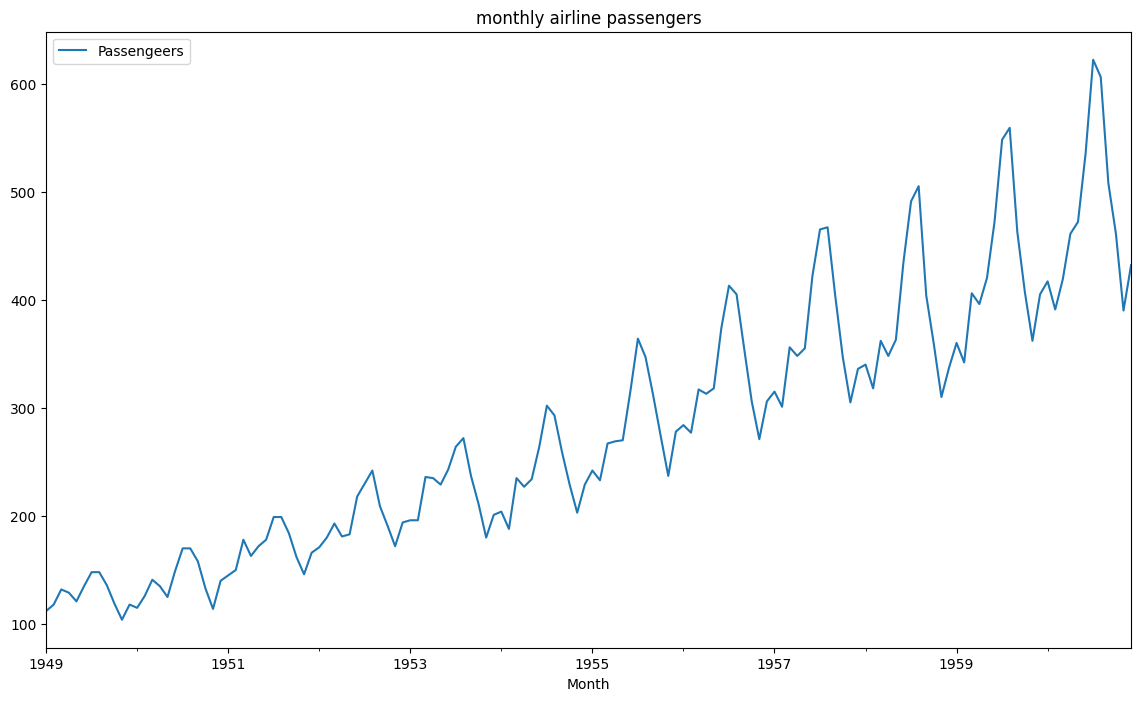

In [266]:
df.plot(figsize=(14,8), title= 'monthly airline passengers');
plt.show()

In [267]:
data= df["Passengeers"].values

In [268]:
type(data[0:5])

numpy.ndarray

In [269]:
type(data[0])

numpy.float64

In [270]:
data= data.astype('float32')

In [271]:
type(data[0])

numpy.float32

In [272]:
data.shape

(144,)

In [273]:
data=data.reshape(-1,1)

In [274]:
data.shape

(144, 1)

In [275]:
def split_data(dataframe, test_size):
  position = int(round(len(dataframe)*(1-test_size)))
  train_data = dataframe[0:position]
  test_data = dataframe[position:]
  return train_data, test_data, position

In [276]:

train_data, test_data, position = split_data(data, 0.33)

In [277]:
print(train_data.shape)
print(test_data.shape)

(96, 1)
(48, 1)


In [278]:
scaler_train = MinMaxScaler(feature_range=(0,1))

In [279]:
train_data = scaler_train.fit_transform(train_data)

In [280]:
scaler_test = MinMaxScaler(feature_range=(0,1))

In [281]:
test_data = scaler_test.fit_transform(test_data)

In [282]:
train_data[:5]

array([[0.02588999],
       [0.04530746],
       [0.09061491],
       [0.08090615],
       [0.05501619]], dtype=float32)

In [283]:
test_data[:5]

array([[0.04361373],
       [0.        ],
       [0.17133951],
       [0.1464175 ],
       [0.16822433]], dtype=float32)

In [284]:
def create_dataset(data, look_back):
  X = []
  Y = []
  for i in range( look_back ,len(data)):
    X.append(data[(i-look_back):i, 0])
    Y.append(data[i, 0])
  return np.array(X), np.array(Y)

In [285]:
look_back = 1

In [286]:
#train datset
x_train, y_train = create_dataset(train_data, look_back)

In [287]:
#test dataset
x_test, y_test = create_dataset(test_data, look_back)

In [288]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(95, 1) (95,)
(47, 1) (47,)


In [289]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [290]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(95, 1, 1) (95, 1)
(47, 1, 1) (47, 1)


In [291]:
#to remove nan values
print(np.isnan(x_train).sum(), np.isnan(y_train).sum())
print(np.isnan(x_test).sum(), np.isnan(y_test).sum())
x_train = np.nan_to_num(x_train)
y_train = np.nan_to_num(y_train)
x_test = np.nan_to_num(x_test)
y_test = np.nan_to_num(y_test)


0 0
0 0


Modeling

In [292]:
model = Sequential()
model.add(SimpleRNN(64, activation='relu', input_shape=(look_back, 1)))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mean_squared_error')

In [293]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)             │ (None, 64)                  │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,289 (16.75 KB)

 Trainable params: 4,289 (16.75 KB)

 Non-trainable params: 0 (0.00 B)

In [294]:
#Optimization
model.compile(loss='mean_squared_error', optimizer='adam')

In [295]:
callbacks = [EarlyStopping(monitor='val_loss',
                           patience=3, verbose=1,
                           mode="min"),
             ModelCheckpoint(filepath='mymodel.keras', monitor='val_loss', mode='min',
                             save_best_only=True,
                             save_weights_only= False,
                             verbose=1)]


In [296]:
history= model.fit(x=x_train, y=y_train,
                   epochs =50,
                   batch_size=1,
                   validation_data=(x_test, y_test),
                   callbacks=callbacks,
                   shuffle=False)

Epoch 1/50
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0072
Epoch 1: val_loss improved from inf to 0.04613, saving model to mymodel.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0073 - val_loss: 0.0461
Epoch 2/50
69/95 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0323
Epoch 2: val_loss improved from 0.04613 to 0.02949, saving model to mymodel.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0277 - val_loss: 0.0295
Epoch 3/50
70/95 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0135
Epoch 3: val_loss improved from 0.02949 to 0.02419, saving model to mymodel.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0122 - val_loss: 0.0242
Epoch 4/50
86/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0064
Epoch 4: val_loss improved from 0.02419 to 0.02261, saving model to mymodel.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0064 - val_loss: 0.0226
Epoch 5/50
75/95 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0042
Epoch 5: val_loss improved from 0.02261 to 0.02220, saving 

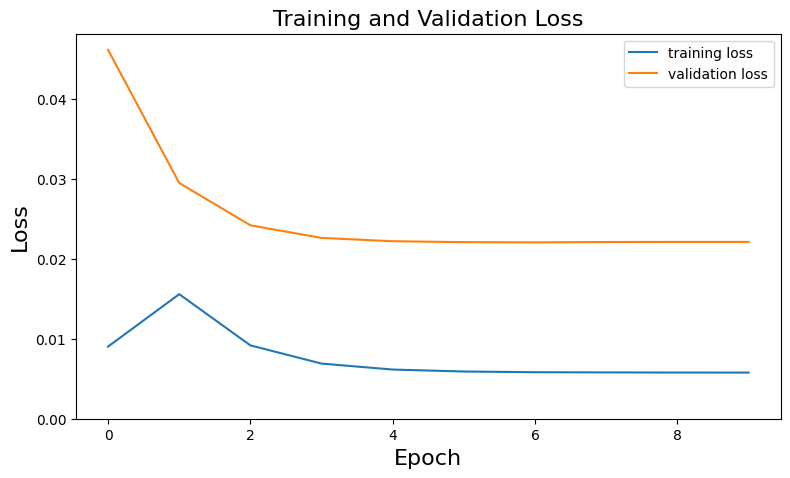

In [297]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss', fontsize=16)
plt.xlabel('Epoch',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.ylim([0,max(plt.ylim())])
plt.show()

In [298]:
#evulation
loss= model.evaluate(x_test, y_test, batch_size=1)
print("\nLoss:%.1f%%" % (100.0* loss))

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0176

Loss:2.2%


In [299]:
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [300]:
train_predict = scaler_train.inverse_transform(train_predict)
test_predict = scaler_test.inverse_transform(test_predict)

In [301]:
y_train = scaler_train.inverse_transform(y_train)
y_test = scaler_test.inverse_transform(y_test)

In [302]:
train_score = np.sqrt(mean_squared_error(y_train, train_predict))
test_score = np.sqrt(mean_squared_error(y_test, test_predict))

In [303]:
print("Train Score: %.2f RMSE" % (train_score))
print("Test Score: %.2f RMSE" % (test_score))

Train Score: 24.26 RMSE
Test Score: 47.73 RMSE


In [304]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Passengeers,144.0,280.298611,119.966317,104.0,180.0,265.5,360.5,622.0


In [305]:
result_df

,Passengeers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0
...,...
1960-08-01,606.0
1960-09-01,508.0
1960-10-01,461.0


In [306]:
train_prediction_df = result_df[look_back:position]

In [307]:
train_prediction_df["Predicted"] = train_predict

In [308]:
train_prediction_df.head()

,Passengeers,Predicted
Month,,
1949-02-01,118.0,125.893539
1949-03-01,132.0,131.367874
1949-04-01,129.0,144.546585
1949-05-01,121.0,141.563278
1949-06-01,135.0,134.105026


In [309]:
test_prediction_df = result_df[position+look_back:]
test_prediction_df["Predicted"] = test_predict
test_prediction_df.head()

,Passengeers,Predicted
Month,,
1957-02-01,301.0,328.934662
1957-03-01,356.0,316.161194
1957-04-01,348.0,368.889587
1957-05-01,355.0,360.934143
1957-06-01,422.0,367.895172


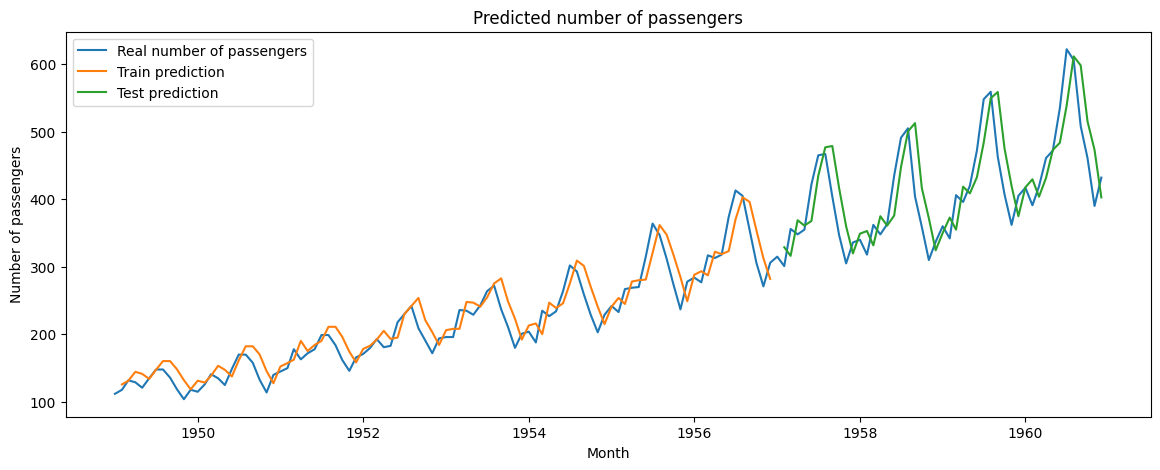

In [310]:
plt.figure(figsize=(14,5))
plt.plot(result_df,label= 'Real number of passengers')
plt.plot(train_prediction_df["Predicted"], label='Train prediction')
plt.plot(test_prediction_df["Predicted"], label='Test prediction')
plt.title('Predicted number of passengers')
plt.xlabel('Month')
plt.ylabel('Number of passengers')
plt.legend()
plt.show()